In [1]:
%matplotlib notebook

In [2]:
# for colab
# !pip install celluloid
# !pip install ffmpeg
# !pip install miniball

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from celluloid import Camera
from matplotlib.animation import FFMpegWriter

from scipy.spatial import ConvexHull
import miniball

### function to generate random polygon

source: https://stackoverflow.com/questions/8997099/algorithm-to-generate-random-2d-polygon

In [4]:
from typing import List, Tuple


def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * np.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = np.random.uniform(0, 2 * np.pi)
    for i in range(num_vertices):
        radius = clip(np.random.normal(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * np.cos(angle),
                 center[1] + radius * np.sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points
  
def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * np.pi / steps) - irregularity
    upper = (2 * np.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = np.random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * np.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles
  
def clip(value, lower, upper):
    """
    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))  

### visualize the polygon

<IPython.core.display.Javascript object>


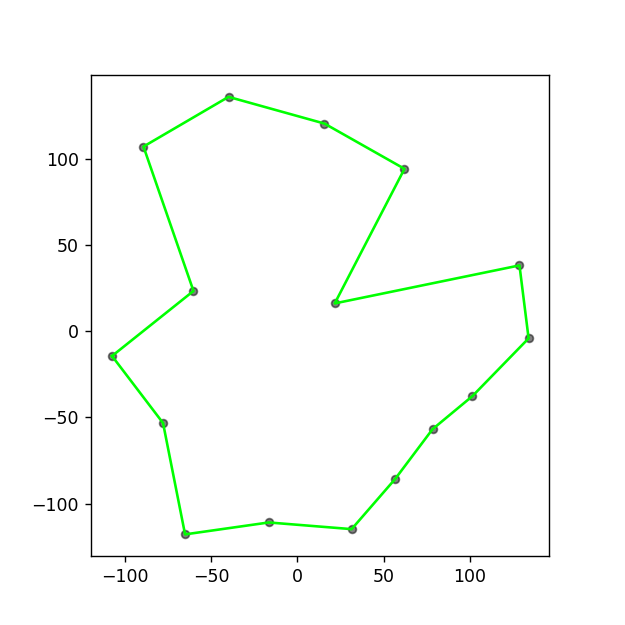

In [104]:
my_poly = np.array(generate_polygon(center=(0,0), avg_radius=100, irregularity=0.35, spikiness=0.2, num_vertices=16))

def plot_poly(x, colr='lime', a=1):
  plt.plot((*x[:,0],x[0,0]),(*x[:,1],x[0,1]), color=colr, alpha=a)
  plt.scatter(x[:,0],x[:,1], color='black', alpha=a/2, s=20)

fig, axs = plt.subplots(figsize=(5,5))
axs.set_aspect('equal')
plot_poly(my_poly)

# try with convex hull if circle inversion fails to find the maximal enclosed circe
# maximal enclosed circle will always be found for convex hull using circle inversion
# ch = ConvexHull(my_poly)
# poly_hull = my_poly[ch.vertices]
# plot_poly(poly_hull, 'red', 0.3)

# my_poly = poly_hull

<IPython.core.display.Javascript object>


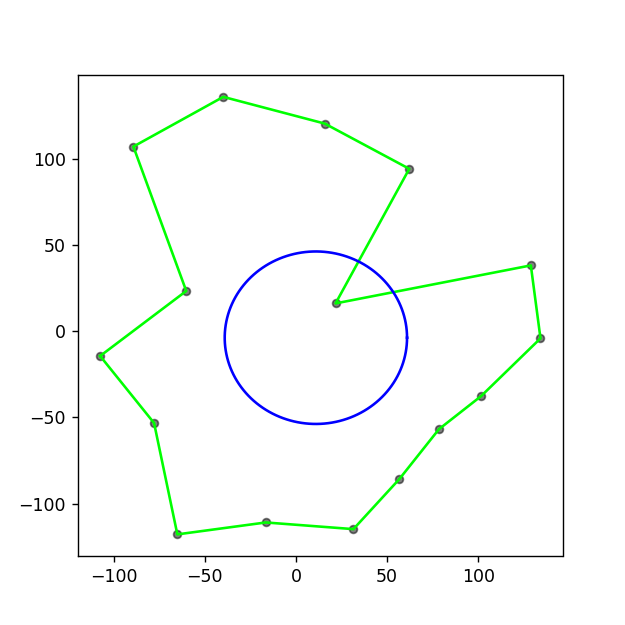

In [103]:
def plot_circle(c, r, frac=1, colr='blue'):
      theta = np.linspace( 0 , 2 * np.pi *frac , 150 )
      a = c[0] + (r * np.cos( theta ))
      b = c[1] + (r * np.sin( theta ))
      #plt.scatter(c[0],c[1])
      plt.plot(a,b, color=colr)
      
      
inv_center = my_poly.mean(axis=0)  # since the center should lie within the circle we want
inv_radius = 50
fig, axs = plt.subplots(figsize=(5,5))
plot_poly(my_poly)
plot_circle(inv_center,inv_radius)

### find maximal enclosed sphere

logic:

First you need to know a point P which you define to be in the circle you seek, for example the centroid of your polygon.
* do an inversion around an arbitrary circle with the center P,
* then find the minimum enclosing circle for your inverted points
* then undo the inversion
The inverse of your minimum enclosing circle should now be a maximum enclosed circle for the original points.

This will only find the maximum enclosed circle for the pointset though, not for the polygon, so if your polygon is self-intersecting or has an otherwise complicated shape, this will not give the desired results

source: https://answers.opencv.org/question/958/i-need-a-maxenclosingcircle-function

minimal enclosing circle
center = [32.11783037 34.95810527], radius = 66.30333631962333
maximal enclosed circle
center = [-10.79107548 -43.35900343], radius = 67.7710543576121


<IPython.core.display.Javascript object>


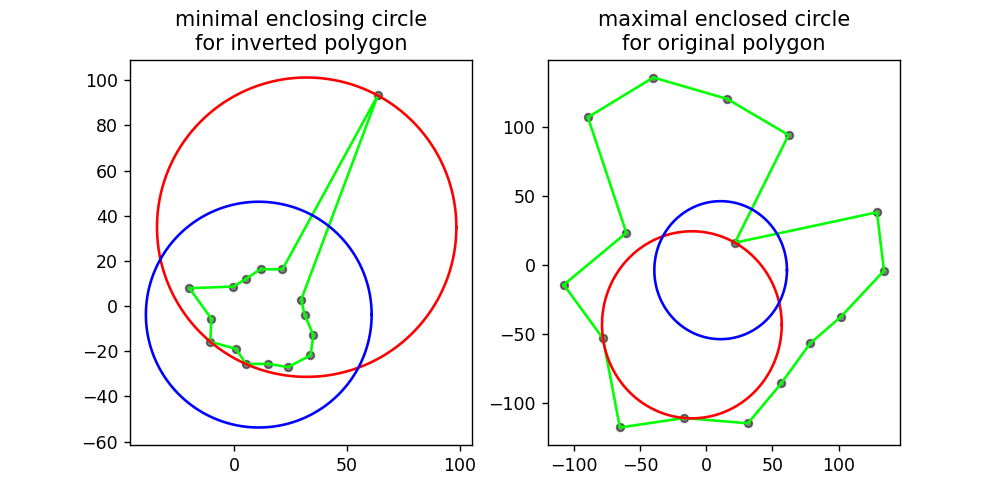

In [129]:
def circ_inv(inv_center, inv_radius, point):
  return inv_center + ( (inv_radius**2) * (point-inv_center) / (np.linalg.norm(point-inv_center,axis=1)**2)[:,None] )
inv_poly = circ_inv(inv_center, inv_radius, my_poly)

min_circ_c, min_circ_r2 = miniball.get_bounding_ball(inv_poly)
min_circ_c = np.array(min_circ_c)
min_circ_r = min_circ_r2**0.5
print('minimal enclosing circle')
print(f'center = {min_circ_c}, radius = {min_circ_r}')

s = (inv_radius**2)  / ( np.linalg.norm(min_circ_c - inv_center)**2 - min_circ_r**2 )
max_circ_r = abs(s) * min_circ_r
max_circ_c = inv_center + s * (min_circ_c - inv_center)
print('maximal enclosed circle')
print(f'center = {max_circ_c}, radius = {max_circ_r}')

fig, axs = plt.subplots(1,2, figsize=(8,4))
plt.axes(axs[0])
plt.gca().set_aspect('equal')
plt.title('minimal enclosing circle\nfor inverted polygon')
plot_poly(inv_poly)
plot_circle(min_circ_c, min_circ_r, colr='red')
plot_circle(inv_center,inv_radius)

plt.axes(axs[1])
plt.title('maximal enclosed circle\nfor original polygon')
plot_poly(my_poly)
plot_circle(max_circ_c, max_circ_r, colr='red')
plot_circle(inv_center,inv_radius)

### generate animation by linear interpolation

<IPython.core.display.Javascript object>


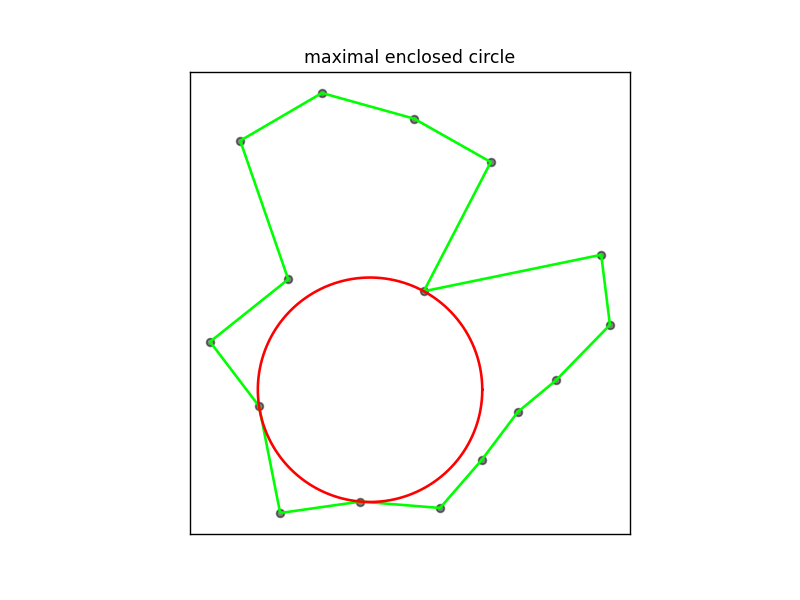

In [109]:
fig, axs = plt.subplots()
axs.set_aspect('equal')
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
camera = Camera(fig)

def lerp(first, last, curr_indx, start=0, stop=99):
  a = (last-first) / (stop - start)
  b = first - start * a
  return a*curr_indx + b


n_frames = 401
for i in range(n_frames):
    
  if i<100:
    frac = i/100
    plot_circle(inv_center, inv_radius, frac=frac)
    plot_poly(my_poly)
    axs.text(0.5, 1.02, "circle inversion", transform=axs.transAxes, ha="center")
    
  elif i<200:
    j = i%100
    curr_poly = lerp(my_poly, inv_poly, j)
    plot_circle(inv_center, inv_radius)
    plot_poly(curr_poly)
    axs.text(0.5, 1.02, "circle inversion", transform=axs.transAxes, ha="center")
    
  elif i<300:
    j = i%100
    frac = j/100
    plot_circle(inv_center, inv_radius)
    plot_circle(min_circ_c, min_circ_r, frac=frac, colr='red')
    plot_poly(inv_poly)
    axs.text(0.5, 1.02, "find minimal enclosing circle", transform=axs.transAxes, ha="center")

  elif i<400:
    j = i%100
    curr_poly = lerp(inv_poly, my_poly, j)
    curr_circle_c = lerp(min_circ_c, max_circ_c, j)
    curr_circle_r = lerp(min_circ_r, max_circ_r, j)

    plot_circle(inv_center, inv_radius)
    plot_circle(curr_circle_c, curr_circle_r, colr='red')
    plot_poly(curr_poly)
    axs.text(0.5, 1.02, "undo inversion", transform=axs.transAxes, ha="center")
    
  else:
    plot_poly(my_poly)
    plot_circle(max_circ_c, max_circ_r, colr='red')
    axs.text(0.5, 1.02, "maximal enclosed circle", transform=axs.transAxes, ha="center")

  camera.snap()

animation = camera.animate(interval=30, repeat=False)

In [13]:
animation.save('max_circ.gif')  # for jupyter
# animation.save('max_circ.mp4', writer=FFMpegWriter(fps=30))  # for colab